In [2]:
import dill 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import pandas as pd
import torch
import pickle
import scipy.stats
from sklearn.model_selection import GroupShuffleSplit

c:\Users\blanc\miniconda3\envs\adaexam\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Patch torch.load to always load tensors on CPU
original_torch_load = torch.load
torch.load = lambda *args, **kwargs: original_torch_load(*args, map_location=torch.device('cpu'), **kwargs)

# Load your pickled model
with open("../results/model_cv.dill", "rb") as f:
    model_cv = dill.load(f)

# Optional: Restore original torch.load
torch.load = original_torch_load

with open("../Data/all_features_glm.pkl", "rb") as f:
    all_features = pickle.load(f)
    
with open("../Data/all_feature_names_glm.pkl", "rb") as f:
    all_feature_names = pickle.load(f)
    
with open("../Data/ca_deconv.pkl", "rb") as f:
    y = pickle.load(f)

In [4]:
def parse_group_from_feature_names(feature_names):
    ''' 
    Parse feature_names into groups using hand-crafted rules

    Input parameters:: 
    feature_names: List of feature names. In this example, expanded features must contain bumpX in the name

    Returns:: 
    group_size: list of number of features in each group
    group_name: name of each group
    group_ind: group index of each feature in feature_names, ndarray of size (len(feature_names),)
    '''
    
    # Find expanded features and their number of sub-features:
    group_size = list()
    group_name = list()
    group_ind = list()
    for name in feature_names:
        if 'bump' not in name:
            # Non-bump expanded feature:
            group_size.append(1)
            group_name.append(name)

        elif 'bump0' in name:
            # First bump of a bump-expanded feature:
            group_size.append(1)
            group_name.append(name[:-6])

        else: 
            # Subsequent time shifts and bumps
            group_size[-1] += 1  

    # Create group index for each feature
    for i_group, this_size in enumerate(group_size):
        group_ind += [i_group]*this_size
    
    return group_size, group_name, np.array(group_ind)


In [5]:
def create_cosine_bumps(x, centers, widths):
  '''Create raised cosine bumps

  Input parameters::
  x: x positions to evaluate the cosine bumps on, ndarray of shape (n_samples, )
  centers: contains center positions of bumps, ndarray of shape (number of bumps, )
  widths: the width of each bump, should be same shape as centers

  Returns::
  bases: basis functions, ndarray of shape (n_samples, number of bumps)
  '''
  # Sanity check
  assert centers.shape == widths.shape, 'Centers and widths should have same number of elements'  
  x_reshape = x.reshape(-1,)

  # Create empty array for basis functions
  bases = np.full((x.shape[0], centers.shape[0]), np.nan)
  
  # Loop over center positions
  for idx, cent in enumerate(centers):
    bases[:, idx] = (np.cos(2 * np.pi * (x_reshape - cent) / widths[idx]) * 0.5 + 0.5) * \
                    (np.absolute(x_reshape - cent) < widths[idx] / 2)
  
  return bases

In [31]:
device = torch.device("cpu")

fs = 1000 
    
group_size, group_name, group_ind = parse_group_from_feature_names(all_feature_names)
print('Number of groups =', len(group_size))
print(group_size)
print(group_name)
    
# Clean up design matrix and z-score along sample dimension
all_features[np.isnan(all_features)] = 0
X = scipy.stats.zscore(all_features, axis = 0)

# Multiply deconvolved activity by 10 to mimic spike number
Y = 10. * y['y']    

# Get indices for splitting according to trial_id 
n_samples = X.shape[0]
group_id = y['trial_index']
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.85, random_state = 42)
train_idx, test_idx = next(gss.split(X, Y, group_id))

# Split data into train and test set
X_train = torch.tensor(X[train_idx,:], dtype=torch.float32).to(device) 
Y_train = torch.tensor(Y[train_idx,:], dtype=torch.float32).to(device) 
X_test = torch.tensor(X[test_idx,:], dtype=torch.float32).to(device)
Y_test = torch.tensor(Y[test_idx,:], dtype=torch.float32).to(device) 
trial_id_train = group_id[train_idx] # extract trial_id for training data, which is used in CV splits later during fitting

y_pred = model_cv.predict(X_test)



Number of groups = 17
[4, 4, 4, 4, 4, 20, 20, 20, 20, 20, 25, 25, 25, 25, 25, 7, 7]
['trialPhase_phase', 'valve_phase', 'conv_stim_phase', 'prev_pulse_flag_phase', 'prev_pulse_strength_phase', 'trialPhase_gap_run', 'valve_gap_run', 'conv_stim_gap_run', 'prev_pulse_flag_gap_run', 'prev_pulse_strength_gap_run', 'trialPhase_prev_gap_run', 'valve_prev_gap_run', 'conv_stim_prev_gap_run', 'prev_pulse_flag_prev_gap_run', 'prev_pulse_strength_prev_gap_run', 'sniff_freq_vec', 'pulse_freq_vec']


In [7]:
with open("../Data/animals_data_processed.pkl", "rb") as f:
    data = pickle.load(f)

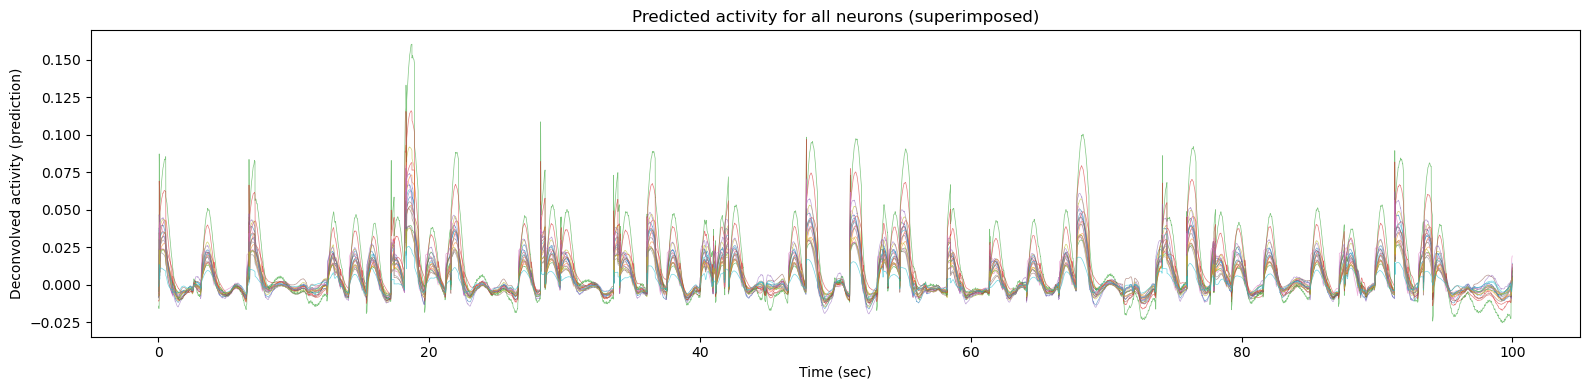

In [8]:
start = 0
n_timepoints = 100000
n_neurons = Y_test.shape[1]

plt.figure(figsize=(16, 4))

for i_neuron in range(n_neurons):
    y_pred_plot = y_pred[start:start+n_timepoints, i_neuron] / 10
    plt.plot(np.arange(n_timepoints)/fs, y_pred_plot, lw=0.5, alpha=0.6)

plt.xlabel("Time (sec)")
plt.ylabel("Deconvolved activity (prediction)")
plt.title("Predicted activity for all neurons (superimposed)")
plt.tight_layout()
plt.show()

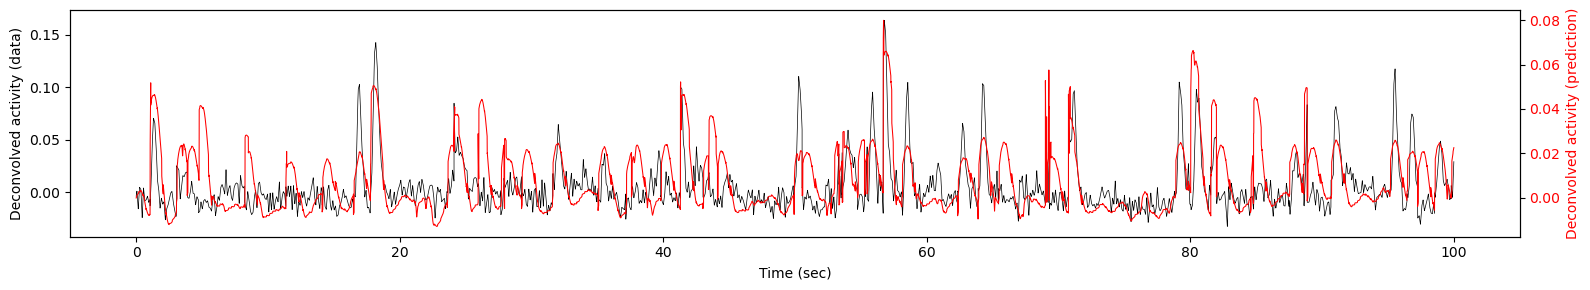

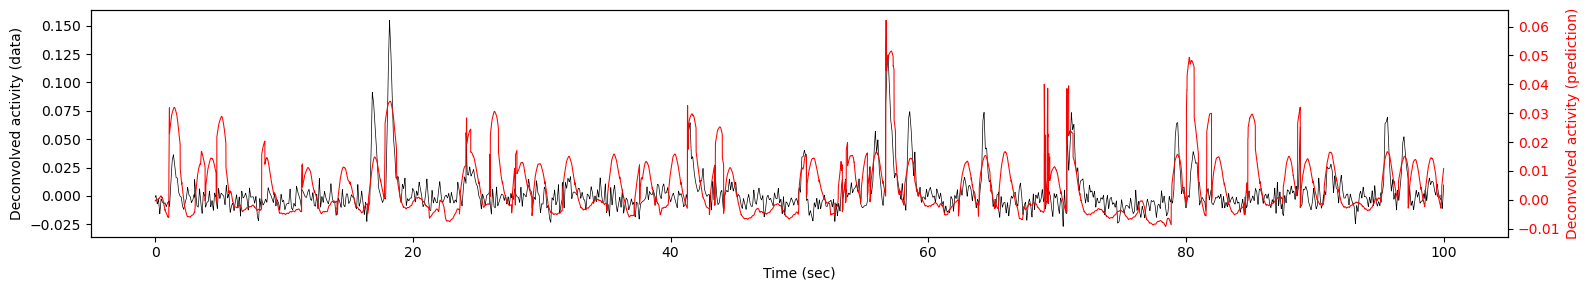

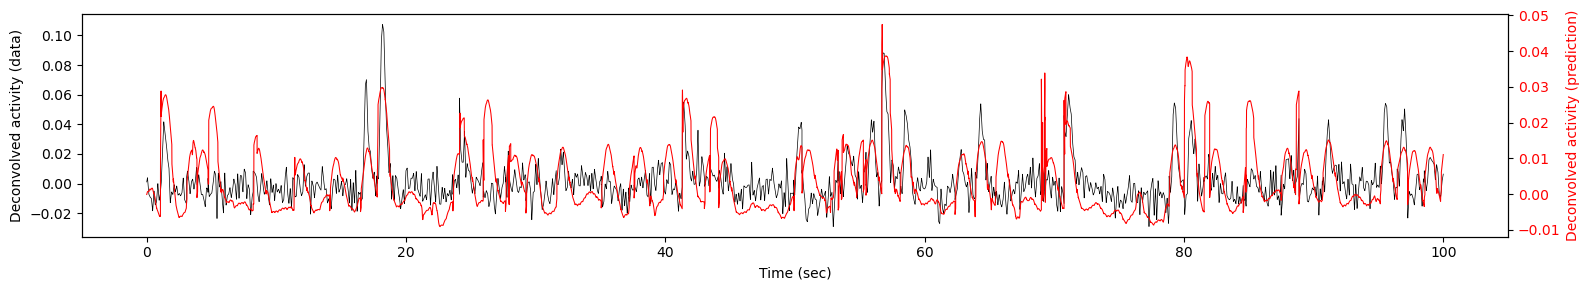

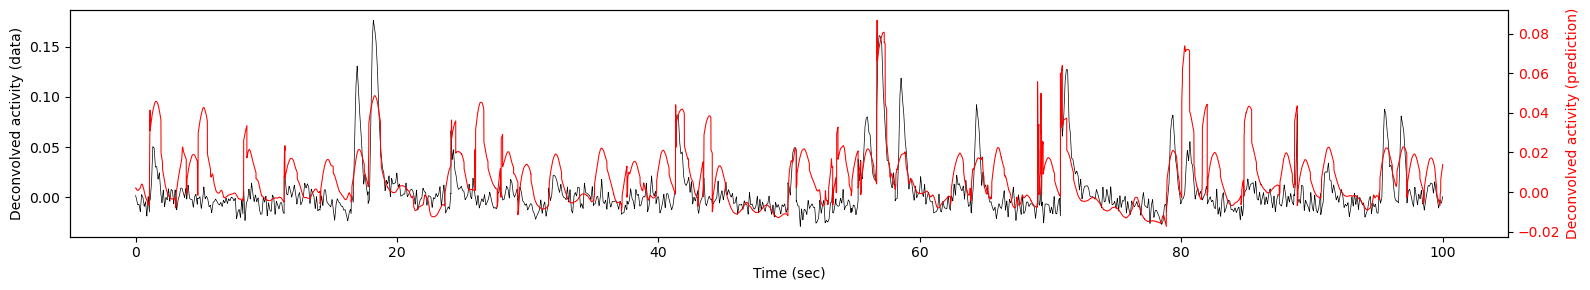

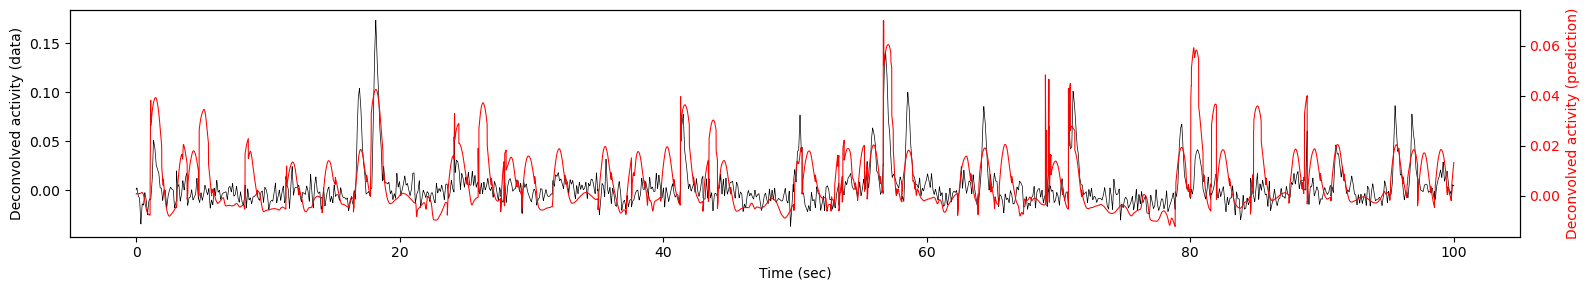

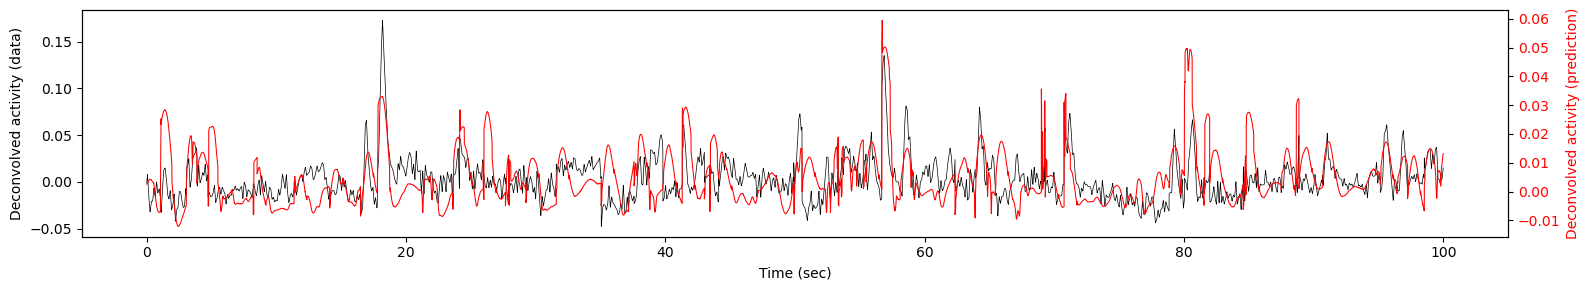

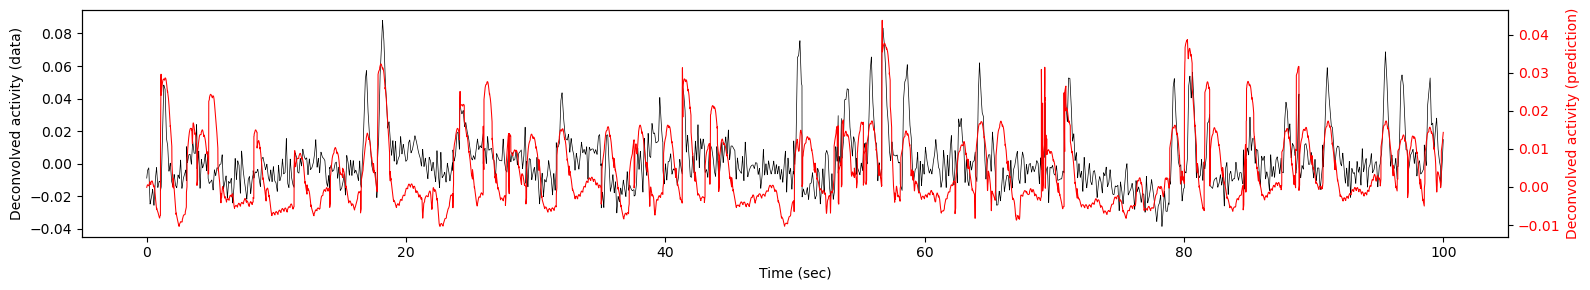

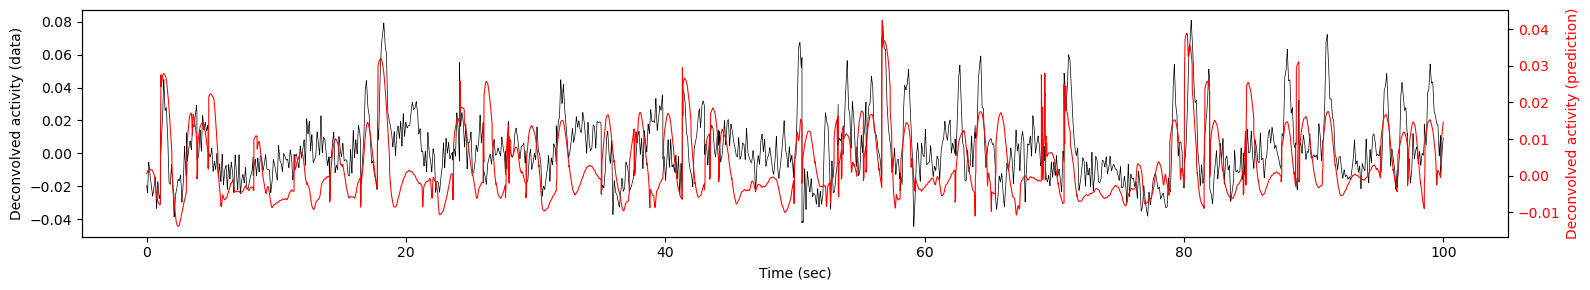

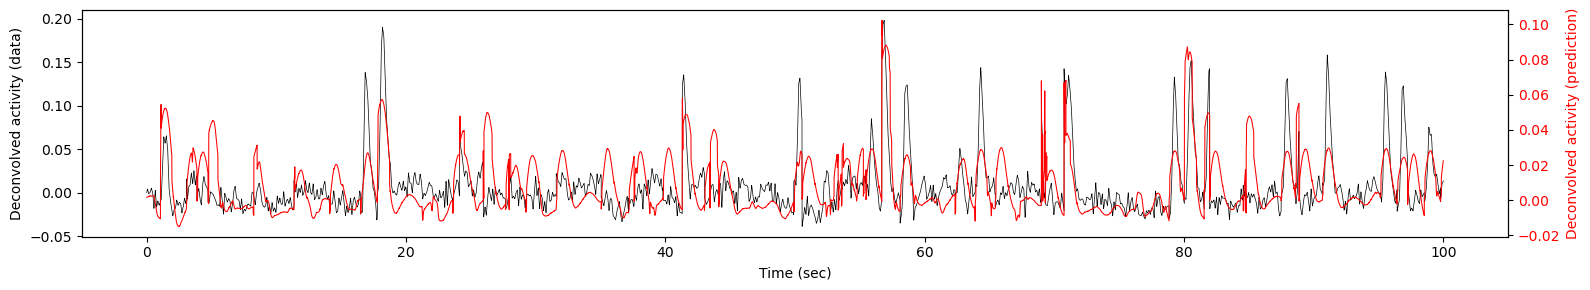

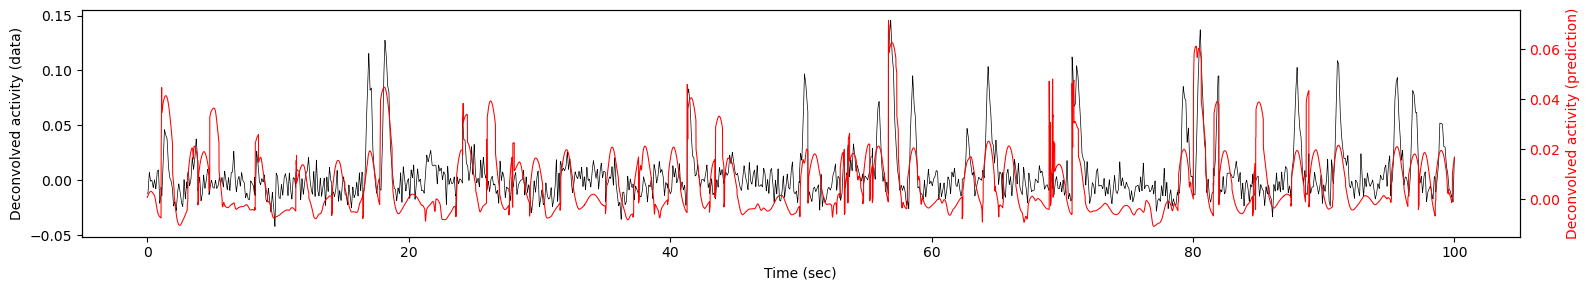

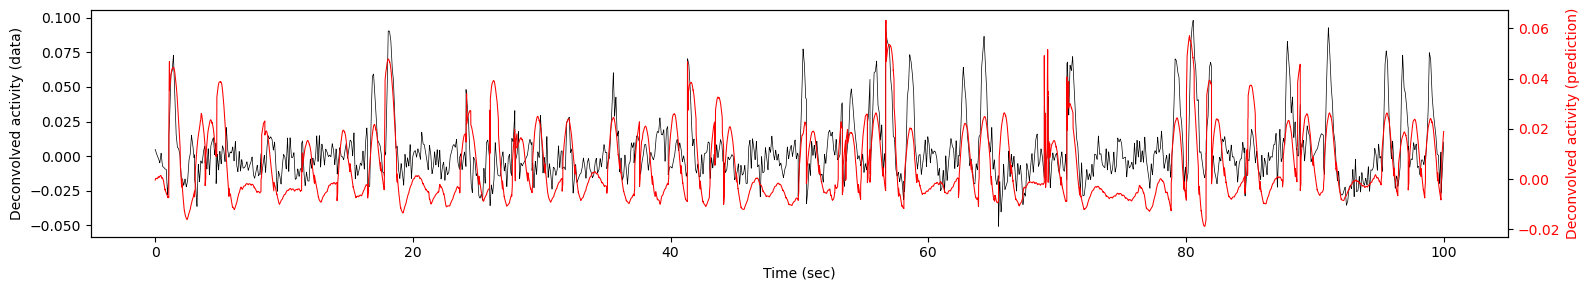

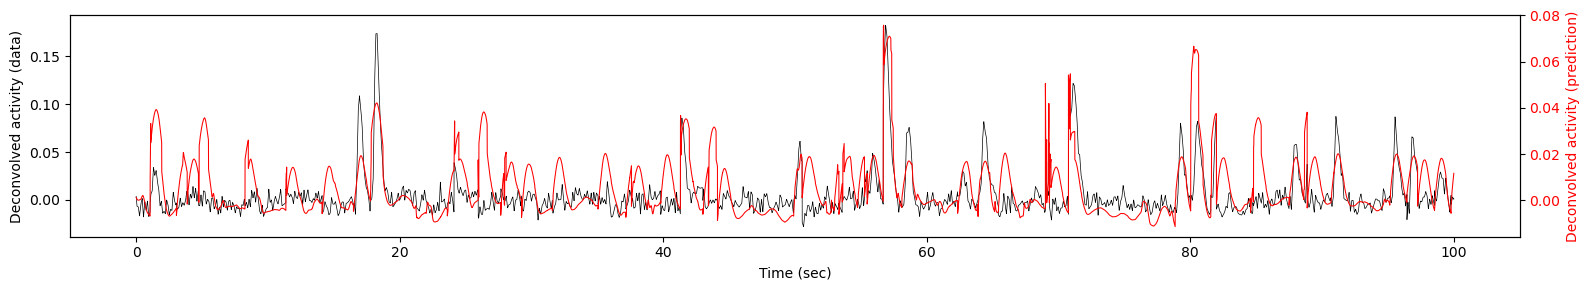

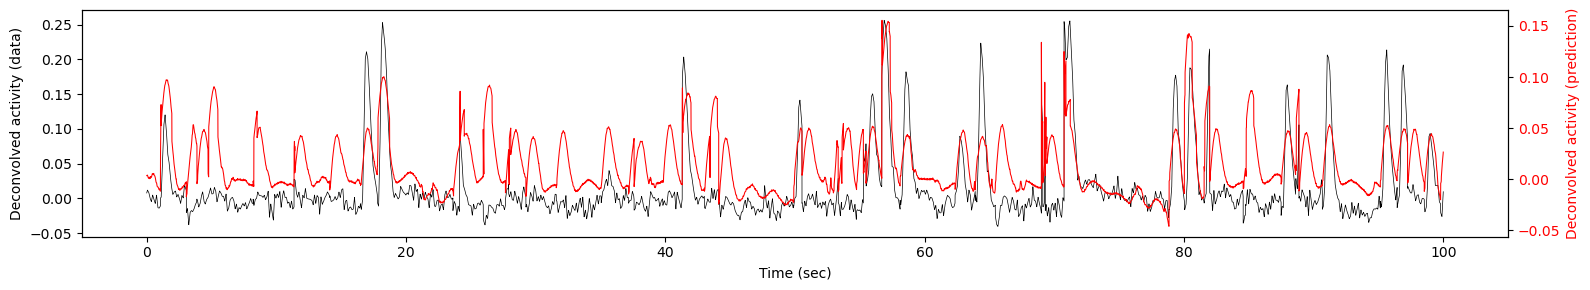

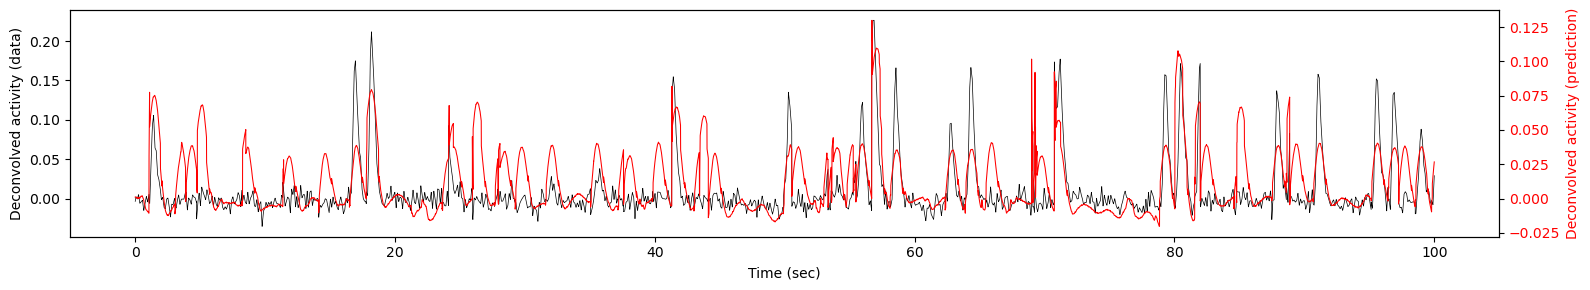

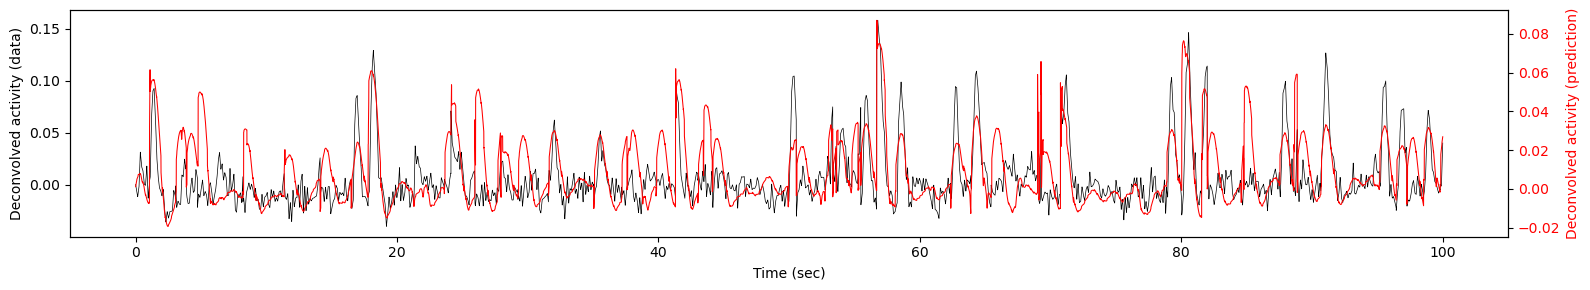

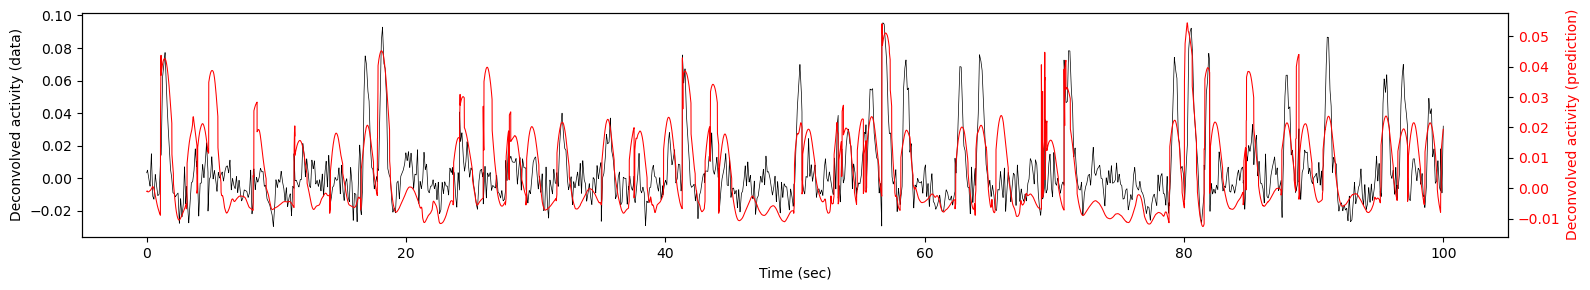

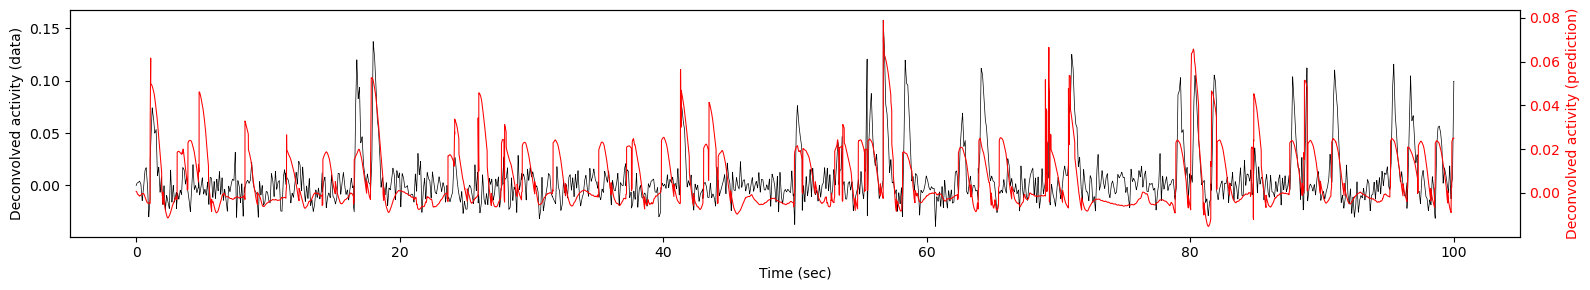

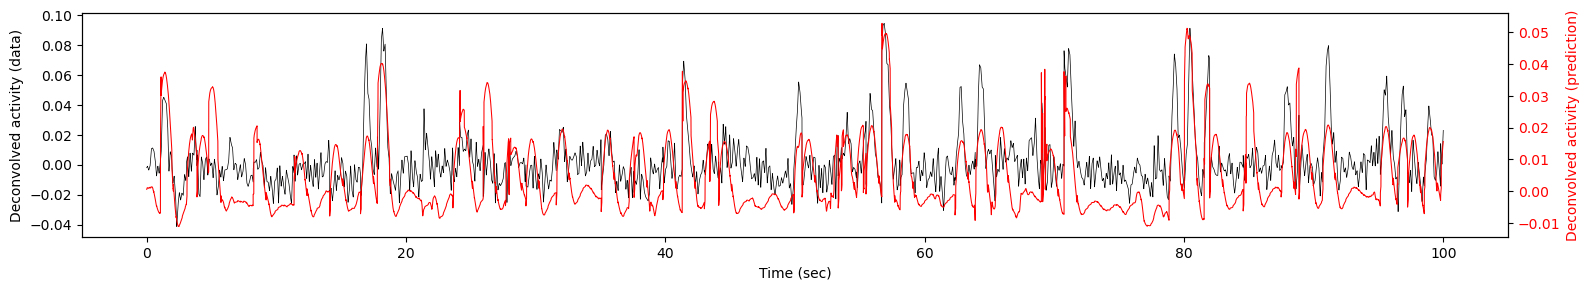

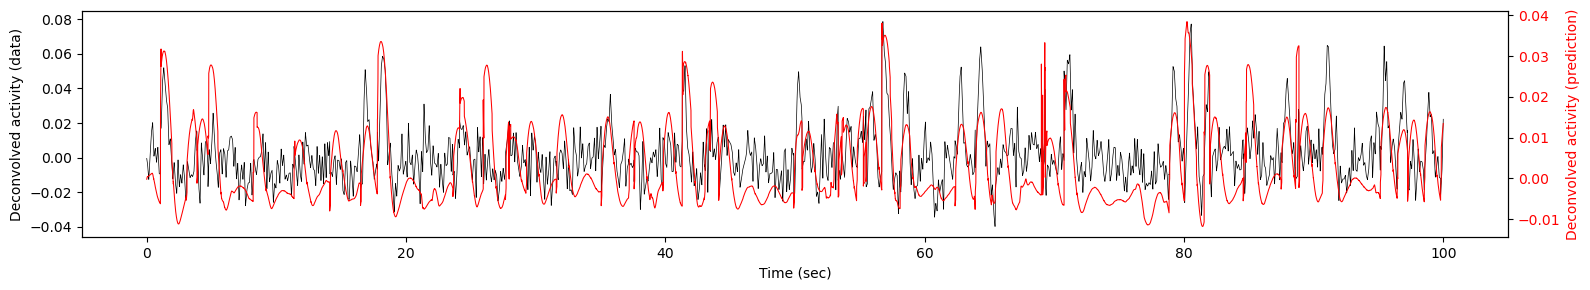

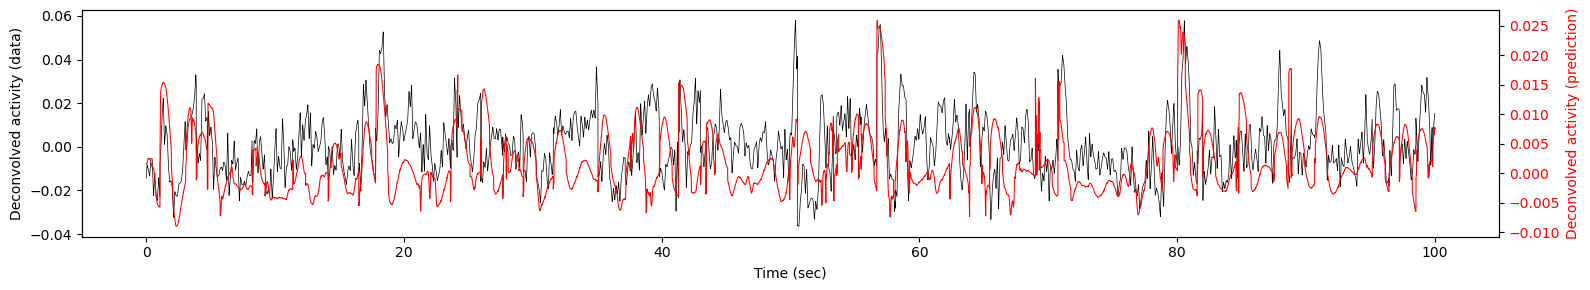

In [9]:
# Compare data and prediction for selected neuron
start = 50000
n_timepoints = 100000

n_neurons = Y_test.shape[1]


for i_neuron in range(n_neurons):
    y_true_plot = Y_test[start:start+n_timepoints, i_neuron].cpu().numpy() / 10
    y_pred_plot = y_pred[start:start+n_timepoints, i_neuron] / 10

    fig, ax1 = plt.subplots(figsize=(16, 3))

    # Plot y_true on the left y-axis
    ax1.plot(np.arange(n_timepoints)/fs, y_true_plot, 'k', lw=0.5, label='data')
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Deconvolved activity (data)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')

    # Create second y-axis for prediction
    ax2 = ax1.twinx()
    ax2.plot(np.arange(n_timepoints)/fs, y_pred_plot, 'r', lw=0.75, label='prediction')
    ax2.set_ylabel('Deconvolved activity (prediction)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    fig.tight_layout()
    plt.show()

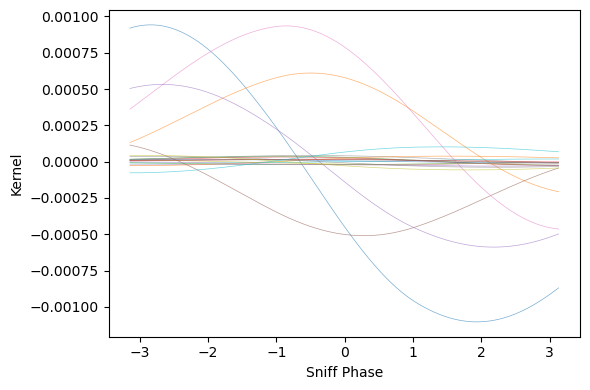

In [11]:
start_phase = -np.pi
end_phase = np.pi
n_phase_bases = 4

phase = data["phase_peaks_dict"]["Sphinx"] - np.pi


phase_centers = np.linspace(start_phase, end_phase, n_phase_bases)

width_to_spacing_ratio = 4
pos_width = width_to_spacing_ratio * scipy.stats.mode(np.diff(phase_centers))[0]

phase_bases = create_cosine_bumps(phase, phase_centers, pos_width * np.ones_like(phase_centers))
phase_names = [f'phase_bump{i}' for i in range(len(phase_centers))] # create a list of names for each expanded feature

# Plot position kernel for the first neuron
i_neuron = 0

# Identify indices for position bases
this_group_name = 'trialPhase_phase'
these_ind = group_ind == group_name.index(this_group_name)

n_neurons = Y_test.shape[1]

plt.figure(figsize=(6, 4))

for i_neuron in range(n_neurons):
    weights = model_cv.selected_w[these_ind, i_neuron]
    tuning = phase_bases @ weights  # shape (n_timepoints,)
    # Sort phase for cleaner plot
    sort_idx = np.argsort(phase)
    phase_sorted = phase[sort_idx]
    tuning_sorted = tuning[sort_idx]
    plt.plot(phase_sorted, tuning_sorted, lw=0.5, alpha=0.6)

plt.xlabel("Sniff Phase")
plt.ylabel('Kernel')
plt.tight_layout()
plt.show()



In [12]:

valve = data["valve_dict"]["Sphinx"]/100
onsets = np.flatnonzero(np.diff(np.r_[0, valve.astype(bool)]) == 1) # detetct pulse onsets

T = len(valve)

trial_index = np.zeros(T, dtype=int)
for k in range(len(onsets) - 1):
    trial_index[onsets[k] : onsets[k+1]] = k
trial_index[onsets[-1] :] = len(onsets) - 1    # tail after last pulse
    
y['trial_index']=trial_index

gap_run = np.zeros(T, dtype=int)
elapsed = 0
current_trial = 0

for t in range(T):
    gap_run[t] = elapsed
    if t + 1 in onsets:          # next sample starts new trial
        elapsed = 0
        current_trial += 1
    else:
        elapsed += 1

prev_gap_run = np.zeros(T, dtype=int)    # starts at gap, then ramps
for k in range(1, len(onsets)):        
    start_cur = onsets[k]
    end_cur = onsets[k+1] if k < len(onsets)-1 else T

    gap_k = onsets[k] - onsets[k-1]      

    # running version: gap + 0,1,2,… within this trial
    length = end_cur - start_cur
    prev_gap_run[start_cur:end_cur] = gap_k + np.arange(length)


## Temporal basis expansion for task variables in time since trial has started/ time since preceding trial has strated

gap_run_s       = gap_run       / fs           # same length as gap_run
prev_gap_run_s  = prev_gap_run  / fs

n_tm_bases_gap_run = 20 
n_tm_bases_prev_gap_run = 25

tm_centers_gap_run      = np.linspace(0, gap_run_s.max(), n_tm_bases_gap_run)
tm_centers_prev_gap_run = np.linspace(0, prev_gap_run_s.max(), n_tm_bases_prev_gap_run)

spacing_gap  = np.diff(tm_centers_gap_run).mean()
spacing_prev = np.diff(tm_centers_prev_gap_run).mean()

tm_width_gap_run      = 4 * spacing_gap
tm_width_prev_gap_run = 4 * spacing_prev

timepoints_gap_run  = np.linspace(0, gap_run_s.max(), 300)
tm_bases_gap_run    = create_cosine_bumps(timepoints_gap_run, tm_centers_gap_run, np.full_like(tm_centers_gap_run, tm_width_gap_run))

timepoints_prev_gap = np.linspace(0, prev_gap_run_s.max(), 300)
tm_bases_prev_gap   = create_cosine_bumps(timepoints_prev_gap, tm_centers_prev_gap_run, np.full_like(tm_centers_prev_gap_run, tm_width_prev_gap_run))

trial_tm_bases_gap_run = create_cosine_bumps(gap_run_s, tm_centers_gap_run, np.full_like(tm_centers_gap_run, tm_width_gap_run))
trial_tm_names_gap_run = [f'gap_run_bump{i}' for i in range(len(tm_centers_gap_run))]

trial_tm_bases_prev_gap_run = create_cosine_bumps(prev_gap_run_s, tm_centers_prev_gap_run, np.full_like(tm_centers_prev_gap_run, tm_width_prev_gap_run))
trial_tm_names_prev_gap_run = [f'prev_gap_run_bump{i}' for i in range(len(tm_centers_prev_gap_run))]

In [45]:
print(group_name[1:])

['valve_phase', 'conv_stim_phase', 'prev_pulse_flag_phase', 'prev_pulse_strength_phase', 'trialPhase_gap_run', 'valve_gap_run', 'conv_stim_gap_run', 'prev_pulse_flag_gap_run', 'prev_pulse_strength_gap_run', 'trialPhase_prev_gap_run', 'valve_prev_gap_run', 'conv_stim_prev_gap_run', 'prev_pulse_flag_prev_gap_run', 'prev_pulse_strength_prev_gap_run', 'sniff_freq_vec', 'pulse_freq_vec']


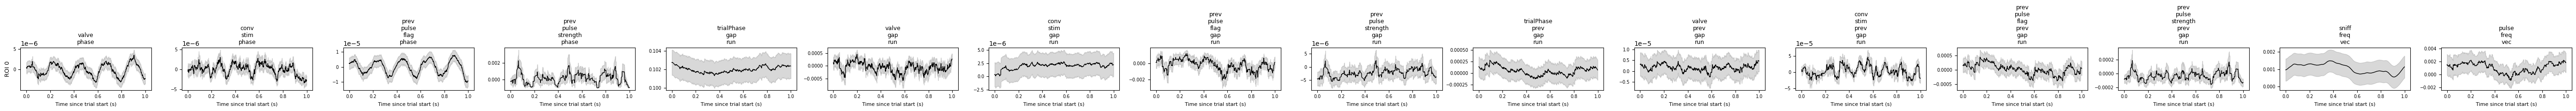

In [ ]:
n_selected_neurons = Y_test.shape[1]
n_groups = len(group_name)
domain = np.arange(Y.shape[0]) / fs  # fallback domain (e.g. time in seconds)

sub_group_name = group_name[1:]

n_selected_neurons = 1
n_groups = 16

fig, axs = plt.subplots(n_selected_neurons, n_groups, figsize=(3.5*n_groups, 2.5*n_selected_neurons), squeeze=False)

for i_neuron in range(n_selected_neurons):
    for i_group in range(n_groups):
                
        ax = axs[i_neuron, i_group]
        
        # Index of this group in weight matrix
        ind = group_ind == i_group+1
        weights = model_cv.selected_w[ind, i_neuron]  # shape = (n_features_in_group,)

        # Determine the corresponding basis for this group
        if sub_group_name[i_group].startswith('trialPhase_phase'):
            basis = phase_bases  # defined earlier
            x_axis = phase
            x_label = 'Sniff phase (rad)'

        elif sub_group_name[i_group].startswith('trialPhase_gap_run'):
            basis = trial_tm_bases_gap_run  # you must have this in memory
            x_axis = np.arange(basis.shape[0]) / fs
            x_label = 'Time since trial start (s)'

        elif sub_group_name[i_group].startswith('trialPhase_prev_gap_run'):
            basis = trial_tm_bases_prev_gap_run  # you must have this
            x_axis = np.arange(basis.shape[0]) / fs
            x_label = 'Time since previous trial start (s)'

        elif sub_group_name[i_group] in ['sniff_freq_vec', 'pulse_freq_vec']:
            # Assuming B-splines are expanded for these, and you saved them as:
            # expanded_features_inst, expanded_feature_names_inst
            names = [n for n in all_feature_names if n.startswith(sub_group_name[i_group] + '_bump')]
            inds = [i for i, n in enumerate(all_feature_names) if n in names]
            basis = X[:, inds]  # or build it again
            x_axis = np.linspace(0, 1, basis.shape[0])  # quantiles
            x_label = sub_group_name[i_group].replace('_', ' ').title()

        else:
            # fallback (e.g. valve_gap_run, etc)
            # Try to reconstruct from your saved trial_tm_bases_gap_run and match
            basis = X[:, ind]  # fallback: actual design matrix
            x_axis = domain
            x_label = 'Time (s)'

        # Compute full kernel
        full_kernel = basis @ weights  # shape = (n_timepoints,)

        # Get start indices of each trial
        trial_starts = np.where(np.diff(trial_id_train, prepend=-1) != 0)[0]

        # Only keep full-length trials (≥1000 timepoints)
        valid_trials = trial_starts[trial_starts + 1000 < len(full_kernel)]

        # Stack first 1000 timepoints of each valid trial
        kernel_snippets = np.stack([full_kernel[start:start+1000] for start in valid_trials], axis=0)

        # Trial-averaged kernel
        """kernel = kernel_snippets.mean(axis=0)
        x_axis = np.arange(1000) / fs
        x_label = 'Time since trial start (s)'

        # Sort for smooth plot if needed
        sort_idx = np.argsort(x_axis)
        ax.plot(x_axis[sort_idx], kernel[sort_idx], label=sub_group_name[i_group])"""
        
        
        # Trial-averaged kernel
        kernel_mean = kernel_snippets.mean(axis=0)
        kernel_sem = kernel_snippets.std(axis=0) / np.sqrt(kernel_snippets.shape[0])
        x_axis = np.arange(1000) / fs
        x_label = 'Time since trial start (s)'

        # Plot with error margins
        ax.plot(x_axis, kernel_mean, color='k', lw=1)
        ax.fill_between(x_axis,
                        kernel_mean - kernel_sem,
                        kernel_mean + kernel_sem,
                        color='gray', alpha=0.3)

        if i_neuron == 0:
            ax.set_title(sub_group_name[i_group].replace('_', '\n'), fontsize=9)
        if i_group == 0:
            ax.set_ylabel(f'ROI {i_neuron}', fontsize=9)

        ax.set_xlabel(x_label, fontsize=8)
        ax.tick_params(labelsize=7)

plt.tight_layout()
plt.show()


In [70]:
import math

def plot_kernels_for_neuron(i_neuron, model_cv, X, group_name, group_ind, all_feature_names,
                             phase_bases, phase, trial_id_train, fs=1000, max_timepoints=1000,
                             n_cols=4):
    """
    Plot a panel of kernels across all feature groups for a given neuron, using multiple rows/columns.

    Parameters:
    - i_neuron: int, index of neuron to visualize
    - model_cv: fitted GLM_CV model
    - X: design matrix (n_samples, n_features)
    - group_name: list of group names
    - group_ind: np.array of group indices (length = n_features)
    - all_feature_names: list of all expanded feature names
    - phase_bases: basis for phase
    - phase: phase array for plotting
    - trial_id_train: np.array of trial indices for each time point
    - fs: sampling frequency
    - max_timepoints: number of timepoints to average across for each trial
    - n_cols: number of columns in the plot grid
    """

    n_groups = len(group_name)
    n_rows = math.ceil(n_groups / n_cols)
    domain = np.arange(X.shape[0]) / fs

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

    for i_group, group in enumerate(group_name):
        row, col = divmod(i_group, n_cols)
        ax = axs[row, col]

        # Index of this group in the weight matrix
        ind = group_ind == i_group
        weights = model_cv.selected_w[ind, i_neuron]

        # Determine basis
        if group.startswith('trialPhase_phase'):
            basis = phase_bases
            x_axis = phase
            x_label = 'Sniff phase (rad)'

        elif group in ['sniff_freq_vec', 'pulse_freq_vec']:
            names = [n for n in all_feature_names if n.startswith(group + '_bump')]
            inds = [i for i, n in enumerate(all_feature_names) if n in names]
            basis = X[:, inds]
            x_axis = np.linspace(0, 1, basis.shape[0])
            x_label = group.replace('_', ' ').title()

        else:
            basis = X[:, ind]
            x_axis = domain
            x_label = 'Time (s)'

        # Compute full kernel
        full_kernel = basis @ weights

        # Find trial start indices
        trial_starts = np.where(np.diff(trial_id_train, prepend=-1) != 0)[0]
        valid_trials = trial_starts[trial_starts + max_timepoints < len(full_kernel)]

        if len(valid_trials) == 0:
            ax.set_title(group)
            ax.text(0.5, 0.5, "No valid trials", ha='center', va='center')
            ax.axis('off')
            continue

        # Average over trials
        kernel_snippets = np.stack([full_kernel[start:start+max_timepoints] for start in valid_trials])
        kernel_mean = kernel_snippets.mean(axis=0)
        kernel_sem = kernel_snippets.std(axis=0) / np.sqrt(kernel_snippets.shape[0])
        x_plot = np.arange(max_timepoints) / fs

        # Plot
        ax.plot(x_plot, kernel_mean, color='k', lw=1)
        ax.fill_between(x_plot, kernel_mean - kernel_sem, kernel_mean + kernel_sem,
                        color='gray', alpha=0.3)
        ax.set_title(group.replace('_', '\n'), fontsize=9)
        ax.set_xlabel(x_label, fontsize=8)
        ax.tick_params(labelsize=7)

        if col == 0:
            ax.set_ylabel(f'ROI {i_neuron}', fontsize=9)

    # Hide empty subplots
    for i in range(n_groups, n_rows * n_cols):
        row, col = divmod(i, n_cols)
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()



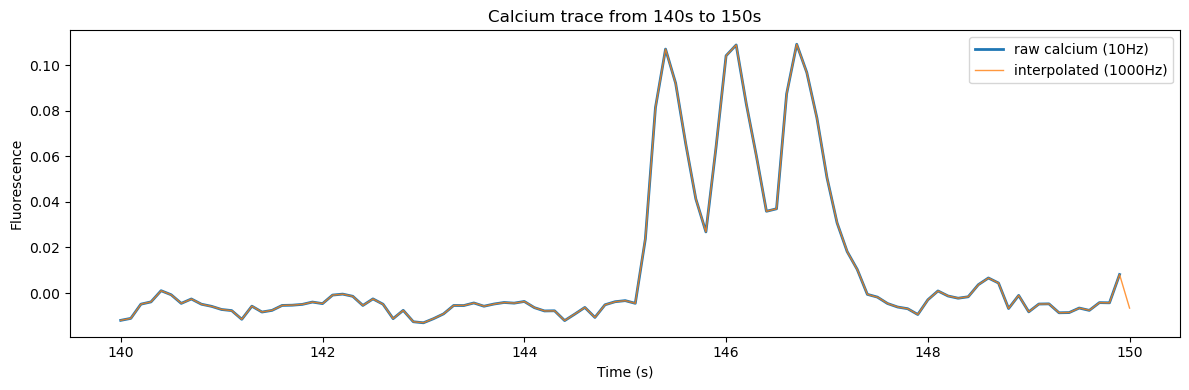

In [86]:
raw_fs = 10        # Hz
interp_fs = 1000   # Hz

raw = data["calcium_dict"]["Sphinx"].mean(axis=1)
interp = data["ca_interp_dict"]["Sphinx"].mean(axis=1)

# Time axes
t_raw = np.arange(len(raw)) / raw_fs
t_interp = np.arange(len(interp)) / interp_fs

# Choose time window to plot
start_time = 140  # seconds
duration_secs = 10

# Compute index ranges
start_idx_raw = int(start_time * raw_fs)
end_idx_raw = int((start_time + duration_secs) * raw_fs)

start_idx_interp = int(start_time * interp_fs)
end_idx_interp = int((start_time + duration_secs) * interp_fs)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t_raw[start_idx_raw:end_idx_raw],
         raw[start_idx_raw:end_idx_raw],
         label='raw calcium (10Hz)', lw=2)
plt.plot(t_interp[start_idx_interp:end_idx_interp],
         interp[start_idx_interp:end_idx_interp],
         label='interpolated (1000Hz)', lw=1, alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence")
plt.title(f"Calcium trace from {start_time}s to {start_time + duration_secs}s")
plt.legend()
plt.tight_layout()
plt.show()


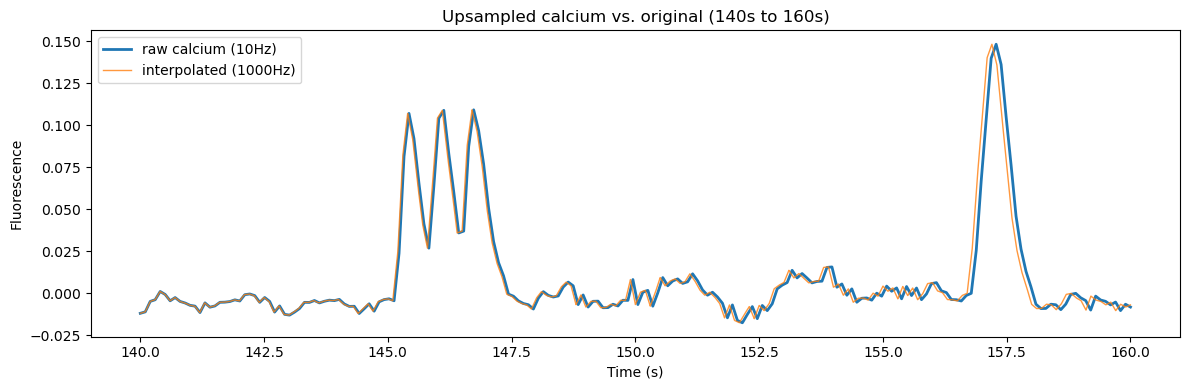

In [88]:
duration_secs = 20
start_time = 140  # change this to any starting point

raw_fs = 10
interp_fs = 1000

raw = data["calcium_dict"]["Sphinx"].mean(axis=1)
interp = data["ca_interp_dict"]["Sphinx"].mean(axis=1)

# Number of points in this window
n_raw = raw_fs * duration_secs
n_interp = interp_fs * duration_secs

# Index ranges for slicing
start_idx_raw = int(start_time * raw_fs)
start_idx_interp = int(start_time * interp_fs)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(start_time, start_time + duration_secs, n_raw),
         raw[start_idx_raw:start_idx_raw + n_raw],
         label='raw calcium (10Hz)', lw=2)

plt.plot(np.linspace(start_time, start_time + duration_secs, n_interp),
         interp[start_idx_interp:start_idx_interp + n_interp],
         label='interpolated (1000Hz)', lw=1, alpha=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Fluorescence")
plt.title(f"Upsampled calcium vs. original ({start_time}s to {start_time + duration_secs}s)")
plt.legend()
plt.tight_layout()
plt.show()


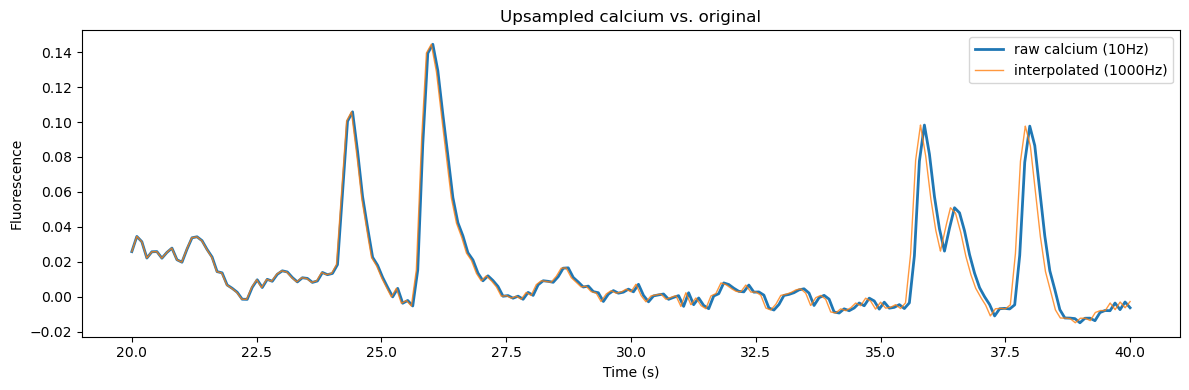

In [87]:
duration_secs = 20# show first 5 seconds for clarity

raw_fs = 10
interp_fs = 1000

raw = data["calcium_dict"]["Sphinx"].mean(axis=1)
interp = data["ca_interp_dict"]["Sphinx"].mean(axis=1)

n_raw = raw_fs * duration_secs
n_interp = interp_fs * duration_secs

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(20, 20+duration_secs, n_raw), raw[:n_raw], label='raw calcium (10Hz)', lw=2)
plt.plot(np.linspace(20, 20+duration_secs, n_interp), interp[:n_interp], label='interpolated (1000Hz)', lw=1, alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence")
plt.title("Upsampled calcium vs. original")
plt.legend()
plt.tight_layout()
plt.show()



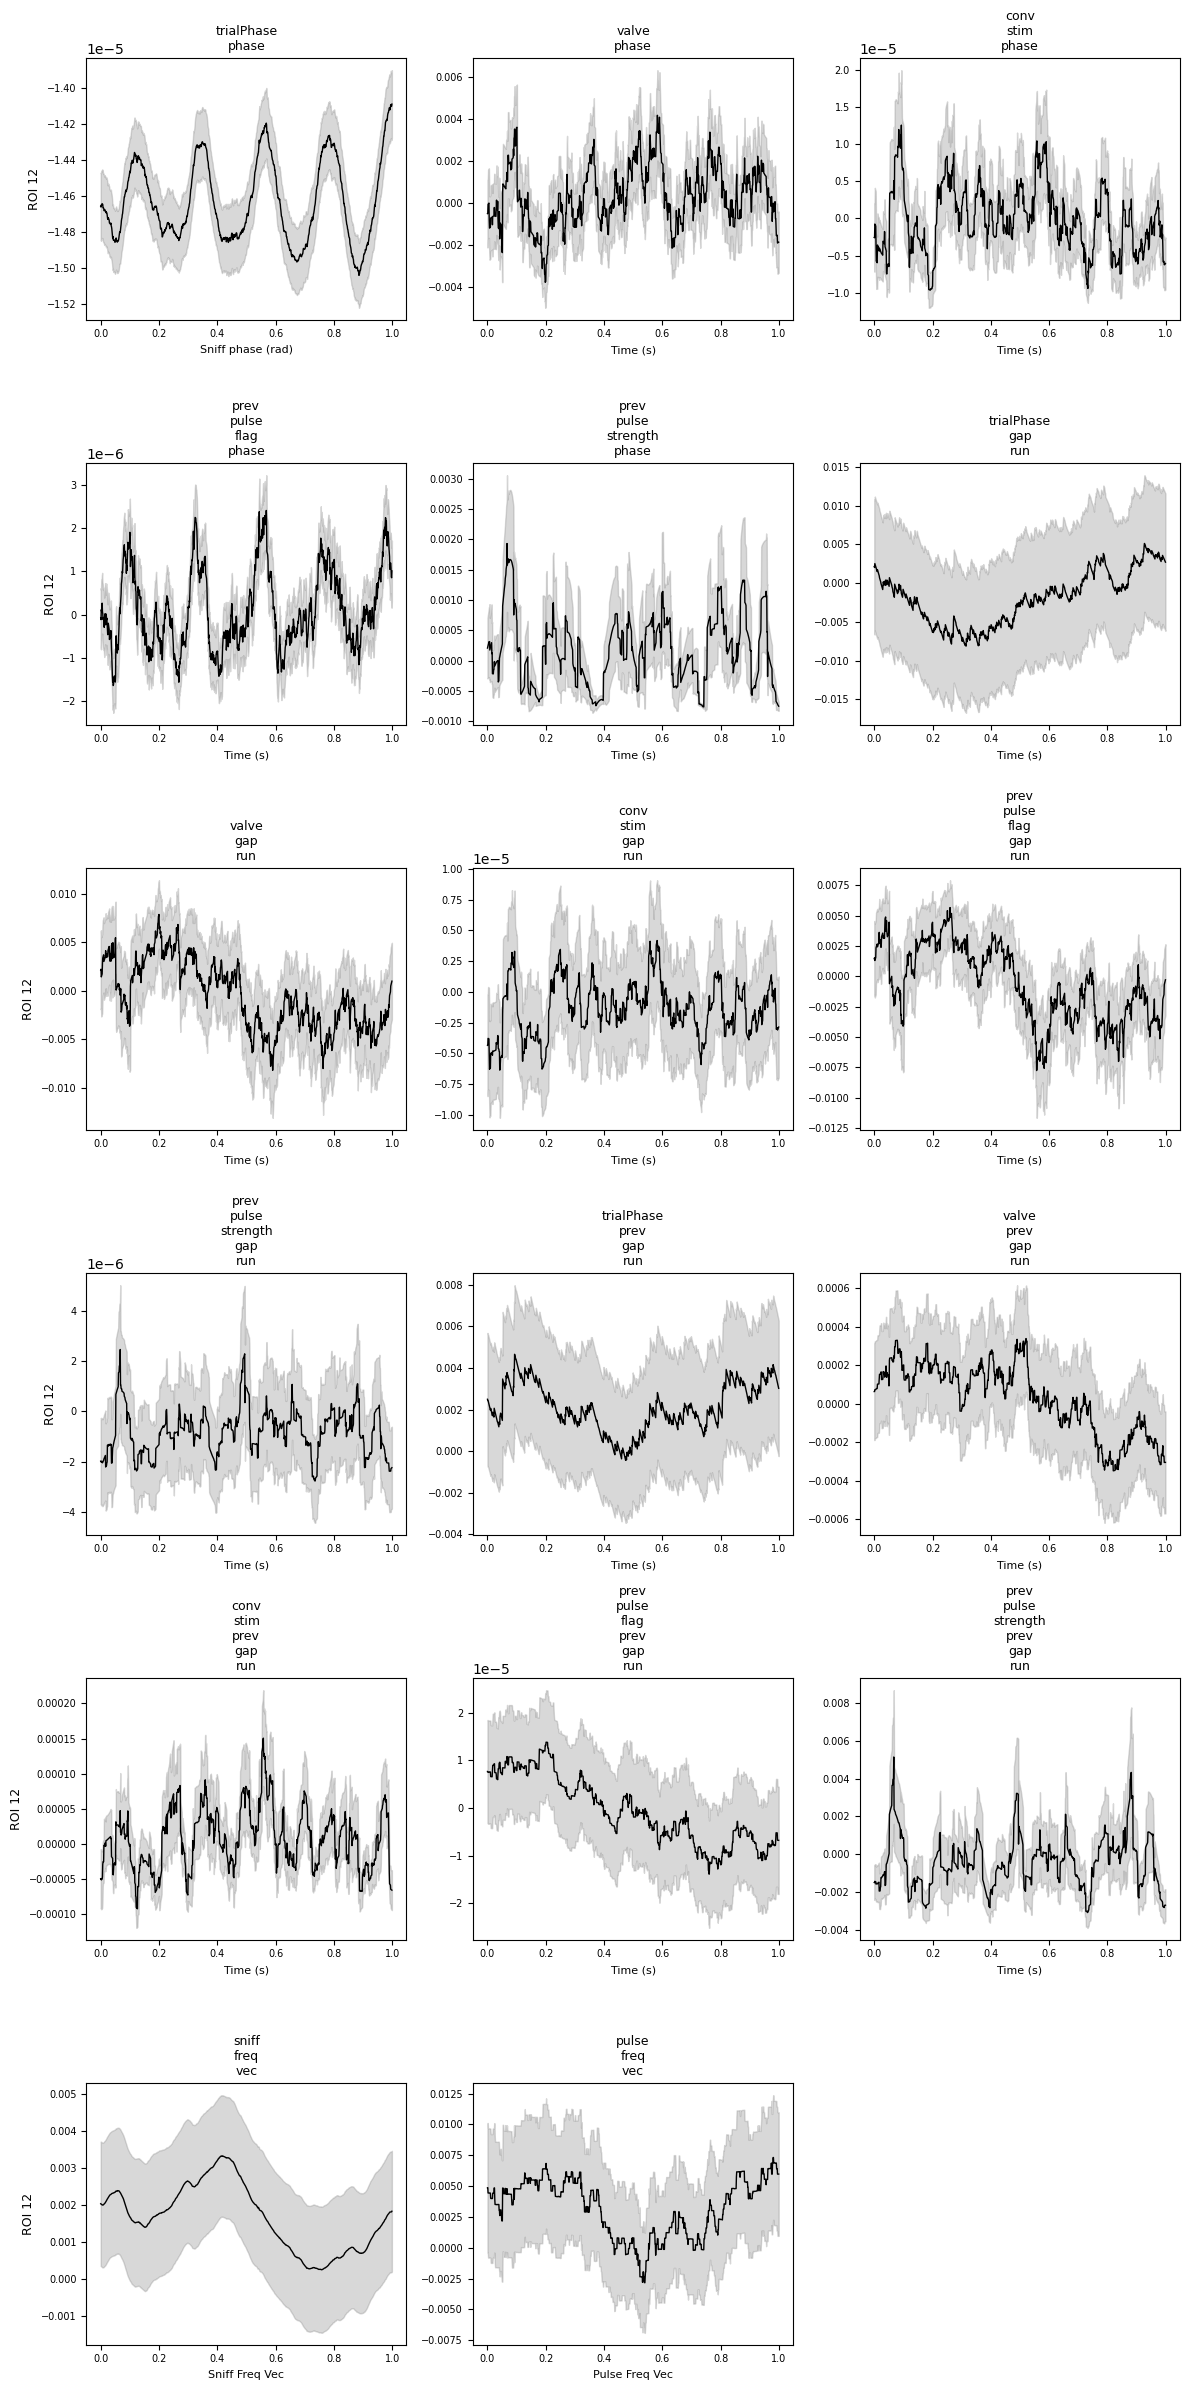

In [72]:
plot_kernels_for_neuron(
    i_neuron=12,
    model_cv=model_cv,
    X=X,
    group_name=group_name,
    group_ind=group_ind,
    all_feature_names=all_feature_names,
    phase_bases=phase_bases,
    phase=phase,
    trial_id_train=trial_id_train,
    fs=1000,
    max_timepoints=1000,
    n_cols=3
)

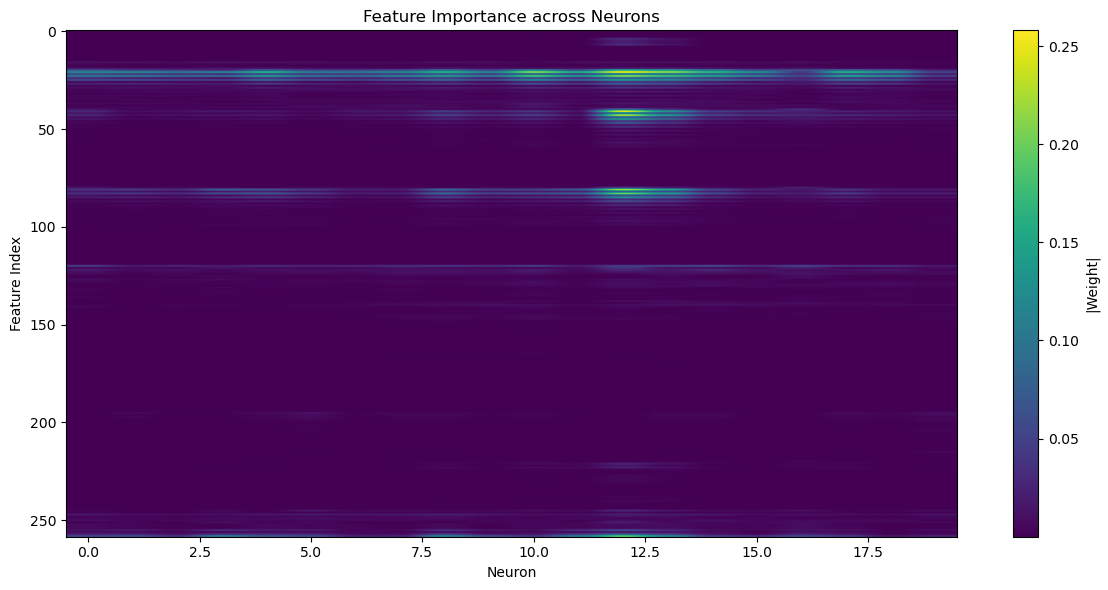

In [55]:
importance = np.abs(model_cv.selected_w)  # shape = (n_features, n_neurons)
# Plot heatmap of importance
plt.figure(figsize=(12, 6))
plt.imshow(importance, aspect='auto', cmap='viridis')
plt.colorbar(label='|Weight|')
plt.xlabel('Neuron')
plt.ylabel('Feature Index')
plt.title('Feature Importance across Neurons')
plt.tight_layout()
plt.show()

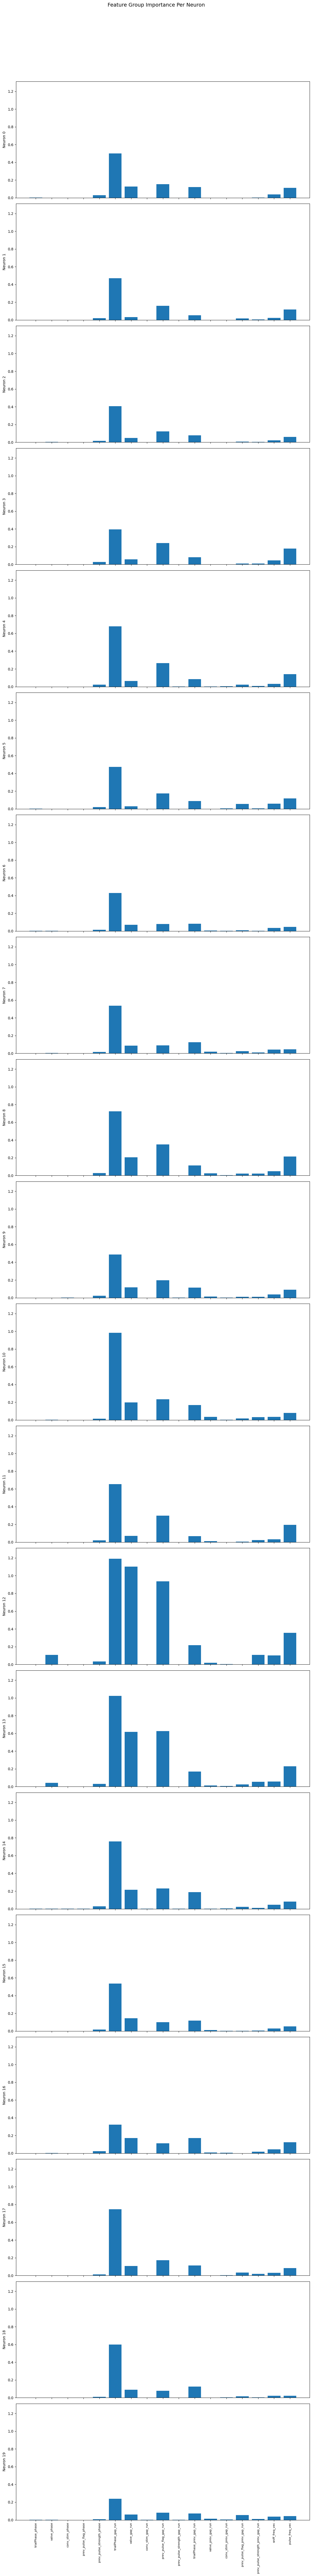

In [61]:
n_neurons = model_cv.selected_w.shape[1]
n_groups = len(group_name)

# Compute absolute weight sum for each group per neuron
importance_per_neuron = np.zeros((n_groups, n_neurons))  # shape (n_groups, n_neurons)

for g in range(n_groups):
    inds = (group_ind == g)
    importance_per_neuron[g, :] = np.sum(np.abs(model_cv.selected_w[inds, :]), axis=0)

# --- Normalize per neuron if desired ---
# importance_per_neuron /= np.sum(importance_per_neuron, axis=0, keepdims=True)

# Plot
fig, axs = plt.subplots(nrows=n_neurons, figsize=(12, n_neurons * 5), sharex=True)

for i in range(n_neurons):
    ax = axs[i] if n_neurons > 1 else axs
    ax.bar(range(n_groups), importance_per_neuron[:, i])
    ax.set_ylabel(f"Neuron {i}")
    ax.set_ylim(0, np.max(importance_per_neuron) * 1.1)
    if i == n_neurons - 1:
        ax.set_xticks(range(n_groups))
        ax.set_xticklabels(group_name, rotation=90, fontsize=8)
    else:
        ax.set_xticks([])

plt.suptitle("Feature Group Importance Per Neuron", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()